# 数据说明

THUCNews是根据新浪新闻RSS订阅频道2005~2011年间的历史数据筛选过滤生成，包含74万篇新闻文档（2.19 GB），均为UTF-8纯文本格式。在原始新浪新闻分类体系的基础上，重新整合划分出14个候选分类类别：财经、彩票、房产、股票、家居、教育、科技、社会、时尚、时政、体育、星座、游戏、娱乐。 格式介绍： 为了使参赛者快速进入比赛核心阶段，我们已将训练集按照“标签ID+\t+标签+\t+原文标题”的格式抽取出来，参赛者可以直接根据新闻标题进行文本分类任务，希望参赛者能够给出自己的解决方案。 训练集格式 标签ID+\t+标签+\t+原文标题 测试集格式 原文标题


In [2]:
import os
import io
import sys
import paddle
import numpy as np
import matplotlib.pyplot as plt
print(paddle.__version__)
import random

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


2.3.2


In [18]:
label_all=[]
with open('./data/Train.txt','r') as f:
    lines=f.readlines()
    print(len(lines))
    label_all.append(lines[0].split('\t')[1])
    for i in range(1,len(lines)):
        if(lines[i].split('\t')[1]!=lines[i-1].split('\t')[1]):
            label_all.append(lines[i].split('\t')[1])
    with open('./data/t.txt','w') as w:
        data=[]
        for s in lines:
            if(len(s.split('\t'))>2):
                data.append(s.split('\t')[0]+'\t'+s.split('\t')[2])
        random.shuffle(data)
        w.writelines(data)
        print(len(data))
print(label_all)

752476
752476
['财经', '彩票', '房产', '股票', '家居', '教育', '科技', '社会', '时尚', '时政', '体育', '星座', '游戏', '娱乐']


In [4]:
# 生成数据字典
def create_dict(data_path, dict_path):
    dict_set = set()
    # 读取全部数据
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # 把数据生成一个元组
    for line in lines:
        content = line.split('\t')[-1].replace('\n', '')
        for s in content:
            dict_set.add(s)
    # 把元组转换成字典，一个字对应一个数字
    dict_list = []
    i = 0
    for s in dict_set:
        dict_list.append([s, i])
        i += 1
    # 添加未知字符
    dict_txt = dict(dict_list)
    end_dict = {"<unk>": i}
    dict_txt.update(end_dict)
    end_dict = {"<pad>": i+1}
    dict_txt.update(end_dict)
    # 把这些字典保存到本地中
    with open(dict_path, 'w', encoding='utf-8') as f:
        f.write(str(dict_txt))
    print("数据字典生成完成！")


In [5]:
# 创建序列化表示的数据,并按照一定比例划分训练数据train_list.txt与验证数据eval_list.txt
def create_data_list(data_list_path):

    with open(os.path.join(data_list_path, 'dict.txt'), 'r', encoding='utf-8') as f_data:
        dict_txt = eval(f_data.readlines()[0])

    with open(os.path.join(data_list_path, 't.txt'), 'r', encoding='utf-8') as f_data:
        lines = f_data.readlines()
    i = 0
    maxlen = 0
    with open(os.path.join(data_list_path, 'eval_list.txt'), 'w', encoding='utf-8') as f_eval,open(os.path.join(data_list_path, 'train_list.txt'), 'w', encoding='utf-8') as f_train:
        for line in lines:
            words = line.split('\t')[-1].replace('\n', '')
            if(len(words)<1):
                continue
            maxlen = max(maxlen, len(words))
            label = line.split('\t')[0]
            labs = ""
            # 每8个 抽取一个数据用于验证
            if i % 8 == 0:
                for s in words:
                    lab = str(dict_txt[s])
                    labs = labs + lab + ','
                labs = labs[:-1]
                labs = labs + '\t' + label + '\n'
                f_eval.write(labs)
            else:
                for s in words:
                    lab = str(dict_txt[s])
                    labs = labs + lab + ','
                labs = labs[:-1]
                labs = labs + '\t' + label + '\n'
                f_train.write(labs)
            i += 1
    print("数据列表生成完成！")
    print("样本最长长度：" + str(maxlen))
    print("总数据数量"+str(i))

In [6]:
# 把生成的数据列表都放在自己的总类别文件夹中
data_root_path = "/home/aistudio/data/" 
data_path = os.path.join(data_root_path, 't.txt')
dict_path = os.path.join(data_root_path, "dict.txt")

# 创建数据字典
create_dict(data_path, dict_path)

# 创建数据列表
create_data_list(data_root_path)

数据字典生成完成！
数据列表生成完成！
样本最长长度：81
总数据数量752475


In [7]:
def load_vocab(file_path):
    fr = open(file_path, 'r', encoding='utf8')
    vocab = eval(fr.read())   #读取的str转换为字典
    fr.close()
    return vocab

In [8]:
# 打印前2条训练数据
vocab = load_vocab(os.path.join(data_root_path, 'dict.txt'))

def ids_to_str(ids):
    words = []
    for k in ids:
        w = list(vocab.keys())[list(vocab.values()).index(int(k))]
        words.append(w if isinstance(w, str) else w.decode('ASCII'))
    return " ".join(words)

file_path = os.path.join(data_root_path, 'train_list.txt')
with io.open(file_path, "r", encoding='utf8') as fin:
    i = 0
    for line in fin:
        cols = line.strip().split("\t")
        if len(cols) != 2:
            sys.stderr.write("[NOTICE] Error Format Line!")
            continue
        label = int(cols[1])
        wids = cols[0].split(",")
        print(str(i)+":")
        print('sentence list id is:', wids)
        print('sentence list is: ', ids_to_str(wids))
        print('sentence label id is:', label)
        print('---------------------------------')
        i += 1
        if i == 2: break

0:
sentence list id is: ['40', '3119', '4063', '1161', '1066', '4596', '3919', '2042', '2299', '4493', '1701', '2513', '3560', '2635', '1532', '4546', '3824', '693', '2249', '5013', '4956']
sentence list is:  6 内 地 房 企 抢 滩 香 港 上 市   民 生 最 快 本 周 递 申 请
sentence label id is: 3
---------------------------------
1:
sentence list id is: ['785', '2374', '969', '2159', '753', '372', '770', '1412', '1161', '2318', '3956', '2513', '4703', '4703', '773', '3089', '5100', '128', '372', '4872', '3959', '2972', '3861', '4767']
sentence list is:  陈 绮 贞 北 京 开 唱 票 房 告 捷   1 1 月 9 日 加 开 一 场 ( 图 )
sentence label id is: 13
---------------------------------


In [21]:

vocab = load_vocab(os.path.join(data_root_path, 'dict.txt'))

class Dataset(paddle.io.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.all_data = []
       
        with io.open(self.data_dir, "r", encoding='utf8') as fin:
            for line in fin:
                cols = line.strip().split("\t")
                if len(cols) != 2:
                    sys.stderr.write("[NOTICE] Error Format Line!")
                    continue
                label = []
                label.append(int(cols[1]))
                wids = cols[0].split(",")
                if len(wids)>=150:
                    wids = np.array(wids[:150]).astype('int64')     
                else:
                    wids = np.concatenate([wids, [vocab["<pad>"]]*(150-len(wids))]).astype('int64')
                label = np.array(label).astype('int64')
                self.all_data.append((wids, label))

        
    def __getitem__(self, index):
        data, label = self.all_data[index]
        return data, label

    def __len__(self):
        return len(self.all_data)


batch_size = 1024
train_dataset = Dataset(os.path.join(data_root_path, 'train_list.txt'))
test_dataset = Dataset(os.path.join(data_root_path, 'eval_list.txt'))

train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)

print('=============train_dataset =============') 
for data, label in train_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break


print('=============test_dataset =============') 
for data, label in test_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break


=============train_dataset =============
[  40 3119 4063 1161 1066 4596 3919 2042 2299 4493 1701 2513 3560 2635
 1532 4546 3824  693 2249 5013 4956 5250 5250 5250 5250 5250 5250 5250
 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250
 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250
 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250
 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250
 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250
 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250
 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250
 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250
 5250 5250 5250 5250 5250 5250 5250 5250 5250 5250]
(150,)
[3]
=============test_dataset =============
[4755 1915 2137 2599 3896 3182 3455 4728 3417 1989 3976 5055 3684 2513
 5236 5011 4728  238 3021 2293 2365  873 2748 4737 5250 5250 5250 5250
 525

In [19]:
import paddle
from paddle.nn import Conv2D, Linear, Embedding
from paddle import to_tensor
import paddle.nn.functional as F

class RNN(paddle.nn.Layer):
    def __init__(self):
        super(RNN, self).__init__()
        self.dict_dim = vocab["<pad>"]
        self.emb_dim = 128
        self.hid_dim = 128
        self.class_dim = len(label_all)
        self.embedding = Embedding(
            self.dict_dim + 1, self.emb_dim,
            sparse=False)
        self._fc1 = Linear(self.emb_dim, self.hid_dim)
        self.lstm = paddle.nn.LSTM(self.hid_dim, self.hid_dim)
        self.fc2 = Linear(19200, self.class_dim)

    def forward(self, inputs):
        # [32, 150]
        emb = self.embedding(inputs)
        # [32, 150, 128]
        fc_1 = self._fc1(emb)
        # [32, 150, 128]
        x = self.lstm(fc_1)
        x = paddle.reshape(x[0], [0, -1])
        x = self.fc2(x)
        x = paddle.nn.functional.softmax(x)
        return x

rnn = RNN()
paddle.summary(rnn,(32,150),"int64")

-----------------------------------------------------------------------------------------------------
 Layer (type)       Input Shape                       Output Shape                      Param #    
  Embedding-4       [[32, 150]]                      [32, 150, 128]                     672,128    
   Linear-7       [[32, 150, 128]]                   [32, 150, 128]                     16,512     
    LSTM-4        [[32, 150, 128]]   [[32, 150, 128], [[1, 32, 128], [1, 32, 128]]]     132,096    
   Linear-8        [[32, 19200]]                        [32, 14]                        268,814    
Total params: 1,089,550
Trainable params: 1,089,550
Non-trainable params: 0
-----------------------------------------------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 14.13
Params size (MB): 4.16
Estimated Total Size (MB): 18.30
-----------------------------------------------------------------------------------------------------



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


{'total_params': 1089550, 'trainable_params': 1089550}

In [10]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

epoch: 0, batch_id: 0, loss is: [2.639565]
epoch: 0, batch_id: 50, loss is: [2.2660835]
epoch: 0, batch_id: 100, loss is: [2.2637713]
epoch: 0, batch_id: 150, loss is: [2.2591686]
epoch: 0, batch_id: 200, loss is: [2.2724428]
epoch: 0, batch_id: 250, loss is: [2.237433]
epoch: 0, batch_id: 300, loss is: [2.2317116]
epoch: 0, batch_id: 350, loss is: [2.2520847]
epoch: 0, batch_id: 400, loss is: [2.2621312]
epoch: 0, batch_id: 450, loss is: [2.2586126]
epoch: 0, batch_id: 500, loss is: [2.2493427]
epoch: 0, batch_id: 550, loss is: [2.2314615]
epoch: 0, batch_id: 600, loss is: [2.2350821]
[validation] accuracy: 0.510817289352417, loss: 2.2400968074798584
epoch: 1, batch_id: 0, loss is: [2.2182465]
epoch: 1, batch_id: 50, loss is: [2.262248]
epoch: 1, batch_id: 100, loss is: [2.220769]
epoch: 1, batch_id: 150, loss is: [2.2345674]
epoch: 1, batch_id: 200, loss is: [2.2580407]
epoch: 1, batch_id: 250, loss is: [2.2523968]
epoch: 1, batch_id: 300, loss is: [2.2009826]
epoch: 1, batch_id: 350

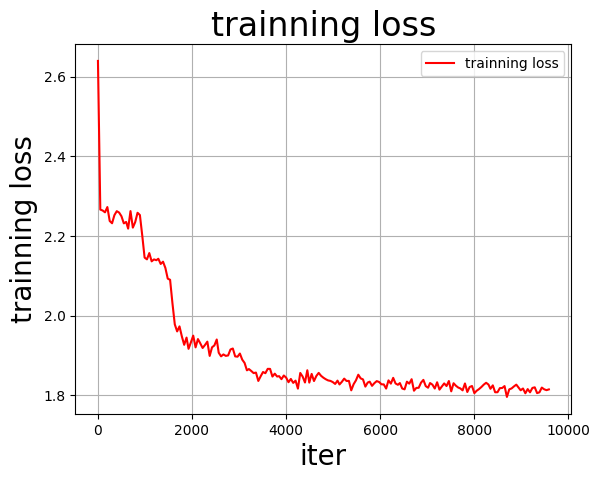

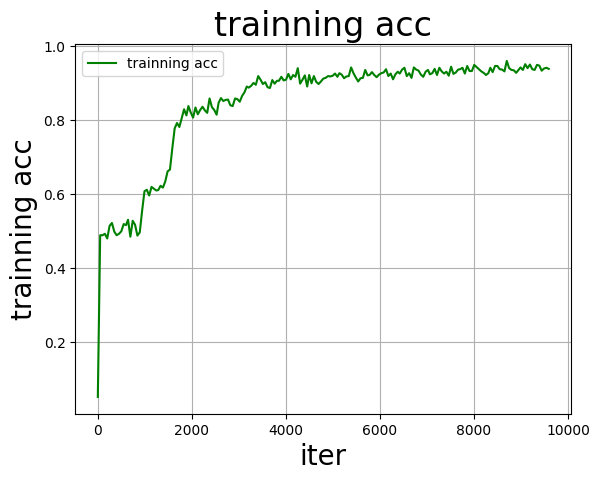

In [24]:
def train(model):
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=0.002, parameters=model.parameters())
    
    steps = 0
    Iters, total_loss, total_acc = [], [], []
    
    for epoch in range(15):
        for batch_id, data in enumerate(train_loader):
            steps += 1
            sent = data[0]
            label = data[1]
            
            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)

            if batch_id % 50 == 0:
                Iters.append(steps)
                total_loss.append(loss.numpy()[0])
                total_acc.append(acc.numpy()[0])

                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        
        for batch_id, data in enumerate(test_loader):
            
            sent = data[0]
            label = data[1]

            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)
            
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)

        print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))
        
        model.train()

    paddle.save(model.state_dict(),"model_final.pdparams")
    
    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")
        
model = RNN()
train(model)

In [38]:
model_state_dict = paddle.load('model_final.pdparams')
model = RNN()
model.set_state_dict(model_state_dict) 
model.eval()

with open('data/dict.txt', 'r', encoding='utf-8') as f_data:
    dict_txt = eval(f_data.readlines()[0])

with open('data/Test.txt', 'r', encoding='utf-8') as f,open("result.txt","w") as w:
    lines=f.readlines()
    print(len(lines))
    for line in lines:
        line=line.strip()
        wids = []
        for s in line:
            if s in dict_txt:
                wids.append(dict_txt[s])
            else:
                wids.append(vocab["<unk>"])
        if len(wids)>=150:
            wids = np.array(wids[:150]).astype('int64')     
        else:
            wids = np.concatenate([wids, [vocab["<pad>"]]*(150-len(wids))]).astype('int64')
        res = model(to_tensor(wids.reshape([1,150])))
        res = np.argmax(res.numpy())
        # print(label_all[res])
        w.write(label_all[res]+'\n')
        

83599
